In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt

%matplotlib inline

from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd '/content/gdrive/My Drive/generate'

/content/gdrive/My Drive/generate


In [5]:
IMAGE_DIR = 'data'
RESULTS_DIR = 'output'

image_size = 64
batch_size = 16

normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

color_jitter_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]
dataset = ConcatDataset(dataset_list)

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

In [7]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

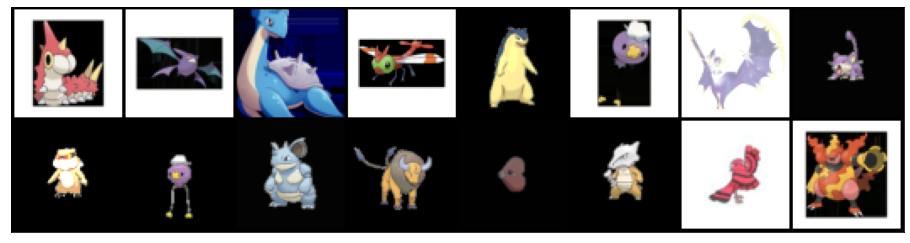

In [9]:
show_batch(dataloader)

In [10]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [11]:
generator = nn.Sequential(
    nn.ConvTranspose2d(16, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
)

In [12]:
def get_training_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dataloader)

In [13]:
device = get_training_device()
dev_dataloader = DeviceDataLoader(dataloader, device)

discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

device

device(type='cuda')

In [14]:
def train_discriminator(real_pokemon, disc_optimizer):
    disc_optimizer.zero_grad()
    
    real_predictions = discriminator(real_pokemon)
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0
    real_loss = F.binary_cross_entropy(real_predictions, real_targets)
    real_score = torch.mean(real_predictions).item()

    latent_batch = torch.randn(batch_size, 16, 1, 1, device=device)

    fake_pokemon = generator(latent_batch)

    gen_predictions = discriminator(fake_pokemon)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() 

    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    
    return total_loss.item(), real_score, gen_score

In [15]:
def train_generator(gen_optimizer):
    gen_optimizer.zero_grad()

    latent_batch = torch.randn(batch_size, 16, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)

    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device)
    loss = F.binary_cross_entropy(disc_predictions, targets)
    loss.backward()
    gen_optimizer.step()

    return loss.item()

In [16]:
def save_results(index, latent_batch, show=True):
    fake_pokemon = generator(latent_batch)
    fake_file = "{0:0=4d}.png".format(index)
    
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Results Saved")
    
    if show:
        fig, ax = plt.subplots(figsize=(16, 16))
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

In [17]:
def train(epochs, learning_rate, start_idx=1):
    torch.cuda.empty_cache()

    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    for epoch in range(epochs):
        for real_img, _ in tqdm(dev_dataloader):
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)
            gen_loss = train_generator(gen_optimizer)

        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch + start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        save_results(epoch + start_idx, torch.randn(64, 16, 1, 1, device=device), show=False)
    
    return disc_losses, disc_scores, gen_losses, gen_scores

In [18]:
learning_rate = 0.0025
epochs = 100

history = train(epochs, learning_rate)


Epoch [1/100], gen_loss: 1.8582, disc_loss: 1.1623, real_score: 0.3882, gen_score: 0.5729
Results Saved



Epoch [2/100], gen_loss: 1.0342, disc_loss: 1.9019, real_score: 0.7484, gen_score: 0.6574
Results Saved



Epoch [3/100], gen_loss: 0.8591, disc_loss: 1.6648, real_score: 0.7052, gen_score: 0.8257
Results Saved



Epoch [4/100], gen_loss: 2.7331, disc_loss: 0.8335, real_score: 0.1635, gen_score: 0.6816
Results Saved



Epoch [5/100], gen_loss: 1.1677, disc_loss: 0.9854, real_score: 0.4129, gen_score: 0.7193
Results Saved



Epoch [6/100], gen_loss: 1.1591, disc_loss: 0.9319, real_score: 0.2592, gen_score: 0.5889
Results Saved



Epoch [7/100], gen_loss: 1.4230, disc_loss: 1.1679, real_score: 0.4960, gen_score: 0.7861
Results Saved



Epoch [8/100], gen_loss: 2.2908, disc_loss: 1.0826, real_score: 0.2616, gen_score: 0.5278
Results Saved



Epoch [9/100], gen_loss: 3.7126, disc_loss: 1.0719, real_score: 0.2025, gen_score: 0.5475
Results Saved



Epoch [10/100], gen_loss: 0.3705, disc_loss: 1.4162, real_score: 0.6741, gen_score: 0.8305
Results Saved



Epoch [11/100], gen_loss: 1.6025, disc_loss: 0.6114, real_score: 0.1928, gen_score: 0.7841
Results Saved



Epoch [12/100], gen_loss: 0.5714, disc_loss: 2.6859, real_score: 0.8188, gen_score: 0.7097
Results Saved



Epoch [13/100], gen_loss: 1.3092, disc_loss: 0.5582, real_score: 0.1328, gen_score: 0.7872
Results Saved



Epoch [14/100], gen_loss: 1.6374, disc_loss: 4.1177, real_score: 0.8722, gen_score: 0.9452
Results Saved



Epoch [15/100], gen_loss: 2.4714, disc_loss: 0.8247, real_score: 0.3988, gen_score: 0.8395
Results Saved



Epoch [16/100], gen_loss: 3.0302, disc_loss: 0.8835, real_score: 0.2872, gen_score: 0.7034
Results Saved



Epoch [17/100], gen_loss: 1.9611, disc_loss: 0.6611, real_score: 0.2747, gen_score: 0.8580
Results Saved



Epoch [18/100], gen_loss: 2.8475, disc_loss: 1.3779, real_score: 0.2751, gen_score: 0.4037
Results Saved



Epoch [19/100], gen_loss: 4.5159, disc_loss: 0.5780, real_score: 0.0438, gen_score: 0.9169
Results Saved



Epoch [20/100], gen_loss: 0.8733, disc_loss: 1.2706, real_score: 0.2366, gen_score: 0.4357
Results Saved



Epoch [21/100], gen_loss: 0.5173, disc_loss: 1.1766, real_score: 0.5543, gen_score: 0.8894
Results Saved



Epoch [22/100], gen_loss: 2.9549, disc_loss: 0.4743, real_score: 0.1397, gen_score: 0.8794
Results Saved



Epoch [23/100], gen_loss: 2.6133, disc_loss: 0.6569, real_score: 0.0188, gen_score: 0.8249
Results Saved



Epoch [24/100], gen_loss: 1.2625, disc_loss: 1.5351, real_score: 0.7260, gen_score: 0.9788
Results Saved



Epoch [25/100], gen_loss: 4.5655, disc_loss: 0.7821, real_score: 0.2864, gen_score: 0.7783
Results Saved



Epoch [26/100], gen_loss: 2.3762, disc_loss: 0.5055, real_score: 0.1438, gen_score: 0.9130
Results Saved



Epoch [27/100], gen_loss: 3.6251, disc_loss: 1.0555, real_score: 0.3215, gen_score: 0.7753
Results Saved



Epoch [28/100], gen_loss: 3.5975, disc_loss: 0.5303, real_score: 0.0038, gen_score: 0.9003
Results Saved



Epoch [29/100], gen_loss: 3.5488, disc_loss: 0.7999, real_score: 0.2776, gen_score: 0.7733
Results Saved



Epoch [30/100], gen_loss: 4.5036, disc_loss: 0.4916, real_score: 0.1690, gen_score: 0.9559
Results Saved



Epoch [31/100], gen_loss: 2.1926, disc_loss: 0.5609, real_score: 0.0036, gen_score: 0.8717
Results Saved



Epoch [32/100], gen_loss: 3.4935, disc_loss: 0.4484, real_score: 0.0778, gen_score: 0.9571
Results Saved



Epoch [33/100], gen_loss: 1.5460, disc_loss: 0.8279, real_score: 0.3119, gen_score: 0.7435
Results Saved



Epoch [34/100], gen_loss: 2.5628, disc_loss: 0.3801, real_score: 0.0139, gen_score: 0.9656
Results Saved



Epoch [35/100], gen_loss: 1.1901, disc_loss: 0.6631, real_score: 0.0052, gen_score: 0.8060
Results Saved



Epoch [36/100], gen_loss: 2.6175, disc_loss: 0.7096, real_score: 0.2385, gen_score: 0.8714
Results Saved



Epoch [37/100], gen_loss: 2.3879, disc_loss: 0.5626, real_score: 0.0105, gen_score: 0.7599
Results Saved



Epoch [38/100], gen_loss: 2.8967, disc_loss: 0.4870, real_score: 0.0579, gen_score: 0.9142
Results Saved



Epoch [39/100], gen_loss: 2.1935, disc_loss: 0.8513, real_score: 0.3479, gen_score: 0.8542
Results Saved



Epoch [40/100], gen_loss: 2.8590, disc_loss: 0.5986, real_score: 0.0251, gen_score: 0.7731
Results Saved



Epoch [41/100], gen_loss: 4.2163, disc_loss: 0.6758, real_score: 0.0202, gen_score: 0.7157
Results Saved



Epoch [42/100], gen_loss: 4.0989, disc_loss: 0.6045, real_score: 0.0507, gen_score: 0.7867
Results Saved



Epoch [43/100], gen_loss: 3.8922, disc_loss: 0.4674, real_score: 0.0286, gen_score: 0.9815
Results Saved



Epoch [44/100], gen_loss: 3.3104, disc_loss: 0.4997, real_score: 0.1004, gen_score: 0.8390
Results Saved



Epoch [45/100], gen_loss: 2.8964, disc_loss: 0.6620, real_score: 0.0009, gen_score: 0.9323
Results Saved



Epoch [46/100], gen_loss: 1.8784, disc_loss: 0.9366, real_score: 0.4484, gen_score: 0.7971
Results Saved



Epoch [47/100], gen_loss: 5.3765, disc_loss: 0.5469, real_score: 0.0321, gen_score: 0.9674
Results Saved



Epoch [48/100], gen_loss: 3.2320, disc_loss: 0.5646, real_score: 0.2110, gen_score: 0.9725
Results Saved



Epoch [49/100], gen_loss: 1.4432, disc_loss: 0.8582, real_score: 0.3368, gen_score: 0.9642
Results Saved



Epoch [50/100], gen_loss: 1.2860, disc_loss: 1.0247, real_score: 0.4972, gen_score: 0.8547
Results Saved



Epoch [51/100], gen_loss: 4.2359, disc_loss: 0.6705, real_score: 0.0347, gen_score: 0.7199
Results Saved



Epoch [52/100], gen_loss: 3.3500, disc_loss: 0.8274, real_score: 0.4142, gen_score: 0.9859
Results Saved



Epoch [53/100], gen_loss: 3.1110, disc_loss: 0.8059, real_score: 0.0112, gen_score: 0.6712
Results Saved



Epoch [54/100], gen_loss: 2.1522, disc_loss: 1.2266, real_score: 0.5994, gen_score: 0.9690
Results Saved



Epoch [55/100], gen_loss: 2.3339, disc_loss: 0.3572, real_score: 0.0257, gen_score: 0.9143
Results Saved



Epoch [56/100], gen_loss: 0.7014, disc_loss: 1.1842, real_score: 0.5866, gen_score: 0.9283
Results Saved



Epoch [57/100], gen_loss: 1.9869, disc_loss: 1.4380, real_score: 0.5064, gen_score: 0.9828
Results Saved



Epoch [58/100], gen_loss: 4.3287, disc_loss: 0.5529, real_score: 0.2613, gen_score: 0.9425
Results Saved



Epoch [59/100], gen_loss: 0.8623, disc_loss: 1.3087, real_score: 0.6680, gen_score: 0.9268
Results Saved



Epoch [60/100], gen_loss: 3.0674, disc_loss: 0.4024, real_score: 0.0218, gen_score: 0.8881
Results Saved



Epoch [61/100], gen_loss: 1.8936, disc_loss: 0.6323, real_score: 0.0034, gen_score: 0.8223
Results Saved



Epoch [62/100], gen_loss: 1.9316, disc_loss: 0.6163, real_score: 0.0021, gen_score: 0.9234
Results Saved



Epoch [63/100], gen_loss: 3.0294, disc_loss: 0.9465, real_score: 0.4824, gen_score: 0.9527
Results Saved



Epoch [64/100], gen_loss: 3.2476, disc_loss: 0.5273, real_score: 0.0793, gen_score: 0.9378
Results Saved



Epoch [65/100], gen_loss: 1.6624, disc_loss: 0.2258, real_score: 0.0186, gen_score: 0.9680
Results Saved



Epoch [66/100], gen_loss: 4.3473, disc_loss: 0.8483, real_score: 0.0442, gen_score: 0.6257
Results Saved



Epoch [67/100], gen_loss: 3.5937, disc_loss: 0.4132, real_score: 0.0767, gen_score: 0.9492
Results Saved



Epoch [68/100], gen_loss: 2.7151, disc_loss: 0.4718, real_score: 0.1357, gen_score: 0.9303
Results Saved



Epoch [69/100], gen_loss: 4.2447, disc_loss: 0.5214, real_score: 0.1487, gen_score: 0.9762
Results Saved



Epoch [70/100], gen_loss: 1.1789, disc_loss: 0.7993, real_score: 0.4289, gen_score: 0.9728
Results Saved



Epoch [71/100], gen_loss: 3.0804, disc_loss: 0.4460, real_score: 0.0379, gen_score: 0.8639
Results Saved



Epoch [72/100], gen_loss: 3.1779, disc_loss: 0.3640, real_score: 0.0590, gen_score: 0.9696
Results Saved



Epoch [73/100], gen_loss: 2.8011, disc_loss: 0.3399, real_score: 0.0149, gen_score: 0.9104
Results Saved



Epoch [74/100], gen_loss: 3.0472, disc_loss: 0.4726, real_score: 0.1332, gen_score: 0.9682
Results Saved



Epoch [75/100], gen_loss: 4.8896, disc_loss: 0.6938, real_score: 0.0314, gen_score: 0.7814
Results Saved



Epoch [76/100], gen_loss: 2.9661, disc_loss: 1.0281, real_score: 0.4984, gen_score: 0.9448
Results Saved



Epoch [77/100], gen_loss: 3.8763, disc_loss: 0.6447, real_score: 0.0651, gen_score: 0.9811
Results Saved



Epoch [78/100], gen_loss: 4.0963, disc_loss: 0.6811, real_score: 0.0055, gen_score: 0.8481
Results Saved



Epoch [79/100], gen_loss: 4.3789, disc_loss: 0.5668, real_score: 0.0326, gen_score: 0.8610
Results Saved



Epoch [80/100], gen_loss: 1.8986, disc_loss: 0.4979, real_score: 0.2203, gen_score: 0.9633
Results Saved



Epoch [81/100], gen_loss: 3.7789, disc_loss: 0.5761, real_score: 0.0058, gen_score: 0.8873
Results Saved



Epoch [82/100], gen_loss: 4.5156, disc_loss: 0.4754, real_score: 0.0499, gen_score: 0.9036
Results Saved



Epoch [83/100], gen_loss: 1.5517, disc_loss: 0.6795, real_score: 0.3027, gen_score: 0.9569
Results Saved



Epoch [84/100], gen_loss: 1.4263, disc_loss: 1.2284, real_score: 0.5475, gen_score: 0.8961
Results Saved



Epoch [85/100], gen_loss: 2.4637, disc_loss: 0.5980, real_score: 0.1464, gen_score: 0.7966
Results Saved



Epoch [86/100], gen_loss: 2.9955, disc_loss: 1.1546, real_score: 0.2420, gen_score: 0.4912
Results Saved



Epoch [87/100], gen_loss: 2.8244, disc_loss: 0.4776, real_score: 0.0468, gen_score: 0.8801
Results Saved



Epoch [88/100], gen_loss: 2.2877, disc_loss: 0.6720, real_score: 0.2048, gen_score: 0.9213
Results Saved



Epoch [89/100], gen_loss: 2.4654, disc_loss: 0.5708, real_score: 0.2084, gen_score: 0.9617
Results Saved



Epoch [90/100], gen_loss: 2.8490, disc_loss: 0.5190, real_score: 0.0413, gen_score: 0.8447
Results Saved



Epoch [91/100], gen_loss: 4.1342, disc_loss: 0.5713, real_score: 0.0039, gen_score: 0.8417
Results Saved



Epoch [92/100], gen_loss: 1.8902, disc_loss: 0.4560, real_score: 0.1607, gen_score: 0.9601
Results Saved



Epoch [93/100], gen_loss: 1.4283, disc_loss: 0.4727, real_score: 0.0675, gen_score: 0.9171
Results Saved



Epoch [94/100], gen_loss: 3.1246, disc_loss: 0.5545, real_score: 0.2024, gen_score: 0.9303
Results Saved



Epoch [95/100], gen_loss: 3.5133, disc_loss: 0.7081, real_score: 0.1832, gen_score: 0.8276
Results Saved



Epoch [96/100], gen_loss: 3.5919, disc_loss: 0.6420, real_score: 0.0355, gen_score: 0.9610
Results Saved



Epoch [97/100], gen_loss: 2.2619, disc_loss: 0.5654, real_score: 0.2255, gen_score: 0.9145
Results Saved



Epoch [98/100], gen_loss: 2.0621, disc_loss: 0.6598, real_score: 0.2377, gen_score: 0.9888
Results Saved



Epoch [99/100], gen_loss: 1.8539, disc_loss: 0.6533, real_score: 0.2825, gen_score: 0.9589
Results Saved



Epoch [100/100], gen_loss: 3.9719, disc_loss: 0.4967, real_score: 0.1417, gen_score: 0.8791
Results Saved
